#### Flow Refueling Location Model (FRLM)

The FRLM is a location-allocation model for optimally locating refueling facilities for range-limited vehicles, such as alt-fuel vehicles. For these vehicles, it may be necessary to stop at more than one facility in order to successfully refuel the entire path length. The model optimally locates $p$ refueling stations on a network so as to maximize the total flow volume refueled. The model could also work for any new network-based, range limited surface transport mode.

**FRLM can be written as:**

$\begin{array}{ll}
\textbf{Max} & \sum\limits_{q \in Q} f_q y_q  \\[0.7em]
\textbf{Subject to:} & \sum\limits_{h \in H} b_{qh} v_h \geq y_q \quad \forall q \in Q  \\[0.7em]
& a_{hk} x_k \geq v_h \quad \forall h \in H; k| a_{hk} =1  \\[0.7em]
& \sum\limits_{k \in K} x_k = p  \\[0.7em]
& x_k, v_h, y_q \in \{0,1\} \quad \forall k, h, q 
\\[0.7em] \end{array}$


$\begin{array}{ll}
q & = \text{index of origin–destination (O–D) pairs} \\
Q & = \text{set of all O–D pairs} \\
f_q & = \text{flow volume on shortest path for O–D pair } q \\
y_q & = \text{1 if flow } q \text{ is refueled, 0 otherwise} \\
k & = \text{potential facility location} \\
K & = \text{set of all potential facility locations} \\
x_k & = \text{1 if a facility is located at } k \text{, 0 otherwise} \\
p & = \text{the number of facilities to be located} \\
h & = \text{index of facility combinations} \\
H & = \text{set of all potential facility combinations} \\
a_{hk} & = \text{a coefficient equal to 1 if facility } k \text{ is in combination } h \text{, 0 otherwise} \\
b_{qh} & = \text{a coefficient equal to 1 if combination } h \text{ can refuel O-D pair} q \text{, 0 otherwise} \\
v_h & = \text{1 if all facilities in combination } h \text{ are open, 0 otherwise}
\end{array}$



_The formulation above is adapted from Kuby and Lim (2005)._

In [2]:
from spopt.locate.flow import FRLM
import numpy as np
import pandas as pd
import pulp
import matplotlib.pyplot as plt
import libpysal
from libpysal import examples
import geopandas as gpd
from libpysal.examples import get_path
import scipy.sparse as sp

In [2]:
%load_ext watermark
%watermark -iv

scipy     : 1.11.3
geopandas : 0.14.1
pulp      : 2.8.0
pandas    : 2.2.1
numpy     : 1.26.4
libpysal  : 4.9.2
matplotlib: 3.8.0



#### Create sample network 

In [3]:
gdf = gpd.read_file(get_path("sids2.shp"))  # Load an example shapfile from libpysa;
gdf = gdf.set_crs(epsg=4326)
gdf_proj = gdf.to_crs(epsg=3857)
H = libpysal.graph.Graph.build_contiguity(gdf_proj, rook=False)

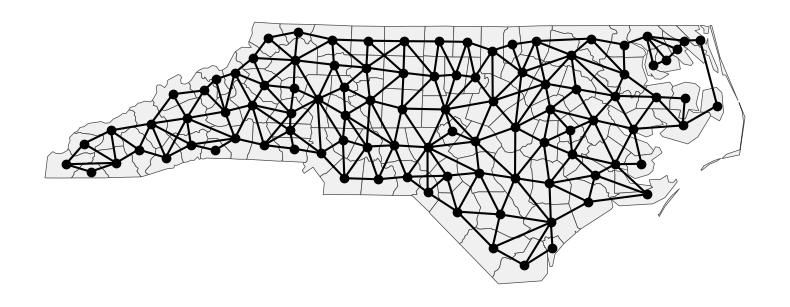

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf_proj.plot(ax=ax, color="#f0f0f0", edgecolor="#444", linewidth=0.5)

H.plot(gdf_proj, ax=ax)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [5]:
# Change libpysal graph to scipy sparse matrix
G = H.sparse
G_csr = sp.csr_matrix(G)

#### Create sample flows


Create Origin-Destination (OD) pairs to represent travel demand across a spatial network. Each tuple in the dataset follows the format `(origin_node, destination_node, flow_volume)`. The flow volumes are the total number of trips between each pair of locations.

In [6]:
np.random.seed(42)

num_nodes = G.shape[0]
nodes = list(range(num_nodes))

od_pairs = []

while len(od_pairs) < 50:
    origin = np.random.choice(nodes)
    dest = np.random.choice(nodes)
    if origin != dest:
        volume = np.random.randint(10, 200)
        od_pairs.append({"origin": origin, "destination": dest, "volume": volume})

flows_df = pd.DataFrame(od_pairs)

In [9]:
flows_df.head()

,origin,destination,volume
0,51,92,24
1,71,60,30
2,82,86,84
3,74,87,126
4,99,23,140


### Basic FRLM model 

In [7]:
frlm_basic = FRLM.from_flow_dataframe(
    p_facilities=1,  # Locate 3 facilities
    vehicle_range=0.2,  # if n >=1 the vehicle range distance is in the same units as the network distances; Optionally, percentage of longest path if 0< n <1
    # uncapacitated model is used by default, set `capacity= ` for capacitated model
    network=G_csr,
    flows=flows_df,
)

In [9]:
frlm_basic

FRLM(vehicle_range=20% of longest path, p=1)

In [ ]:
frlm_basic.problem.writeLP("frlm_basic.lp")

In [8]:
frlm_basic.solve(solver=pulp.GUROBI_CMD())  # use solver='greedy' for greedy solver

{'status': 'Optimal', 'objective_value': 529, 'selected_facilities': [62]}

- Retrieve flow/vmt coverage details, and get Dict with coverage info for each OD pair
```python
flow_coverage = model.get_flow_coverage()
vmt_coverage = model.get_vmt_coverage()
```

 - Retrieve node coverage percentage
```python
node_coverage_pct = model.get_node_coverage_percentage()
```

 - Get all available statistics in one call
```python
details = model.get_detailed_results()
```



In [9]:
result = frlm_basic.get_flow_coverage()
result

{'covered_volume': 529.0, 'flow_volume': 4531, 'covered_proportion': 0.12}

In [10]:
results_basic = frlm_basic.get_detailed_results()
results_basic

{'model_parameters': {'vehicle_range': 3.4,
  'p_facilities': 1,
  'capacity': None,
  'threshold': 0.0,
  'objective_type': 'flow'},
 'solution': {'status': 'Optimal',
  'objective_value': 529.0,
  'selected_facilities': [62],
  'solution_time': 0.09},
 'solver_statistics': {},
 'coverage_statistics': {'flow_breakdown': {(51, 92): {'flow_volume': 24,
    'covered_proportion': 0.0,
    'covered_volume': 0.0},
   (71, 60): {'flow_volume': 30,
    'covered_proportion': 0.0,
    'covered_volume': 0.0},
   (82, 86): {'flow_volume': 84,
    'covered_proportion': 0.0,
    'covered_volume': 0.0},
   (74, 87): {'flow_volume': 126,
    'covered_proportion': 0.0,
    'covered_volume': 0.0},
   (99, 23): {'flow_volume': 140,
    'covered_proportion': 0.0,
    'covered_volume': 0.0},
   (21, 52): {'flow_volume': 11,
    'covered_proportion': 0.0,
    'covered_volume': 0.0},
   (87, 29): {'flow_volume': 47,
    'covered_proportion': 1.0,
    'covered_volume': 47.0},
   (1, 63): {'flow_volume': 197,

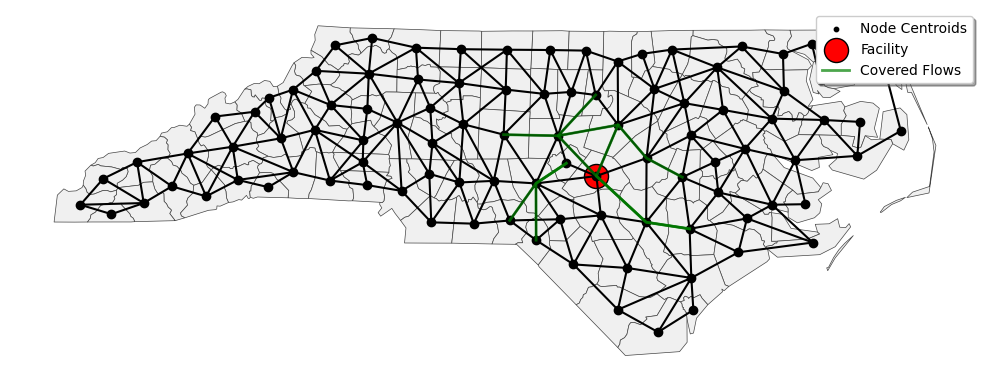

In [11]:
coords = np.array([geom.centroid.coords[0] for geom in gdf_proj.geometry])

fig, ax = plt.subplots(figsize=(10, 10))
gdf_proj.plot(ax=ax, color="#f0f0f0", edgecolor="#444", linewidth=0.5)

H.plot(gdf_proj, ax=ax)

ax.scatter(coords[:, 0], coords[:, 1], color="black", s=10, label="Node Centroids")

if frlm_basic is not None:
    for i, (facility, count) in enumerate(frlm_basic.selected_facilities.items()):
        ax.scatter(
            coords[facility][0],
            coords[facility][1],
            c="red",
            s=300 * (count**0.7),
            alpha=1,
            edgecolors="black",
            label="Facility" if i == 0 else None,  # Only label once
        )

    if frlm_basic.flow_coverage:
        covered_label_added = False

        for od_pair, coverage in frlm_basic.flow_coverage.items():
            if coverage["covered_proportion"] > 0:
                path = frlm_basic.flow_paths[od_pair]
                path_coords = coords[path]
                ax.plot(
                    path_coords[:, 0],
                    path_coords[:, 1],
                    "g-",
                    linewidth=2 * coverage["covered_proportion"],
                    alpha=0.7,
                    label="Covered Flows" if not covered_label_added else None,
                )
                covered_label_added = True

ax.set_axis_off()
ax.legend(loc="upper right", fontsize=10, frameon=True, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

The red dot indicates the selected facility location. Green lines show the OD flows that are covered by the selected facility.

### FRLM threshold extension

The FRLM threshold extension is based on the original FRLM. The extended model optimally locates $p$ refueling stations on a network to maximize the sum of weighted demand of covered origin/destination zones, where 'covered' means that the zone exceeds a specified threshold percentage of their total outbound/inbound round trips that are refuelable. 

**FRLM threshold extension can be written as:**

$\begin{array}{ll}
\textbf{Max}  \; W \sum_j w_j c_j + (1 - W) \frac{\sum_q y_q f_q}{\sum_q f_q} \\[0.7em]
\textbf{Subject to:}  \sum_{i \in K^q_{jk}} z_i \ge y_q \quad \forall q \in Q,\; a_{jk} \in A_q \\[0.7em]
\sum_i z_i = p \\[0.7em]
\frac{\sum_{q \in S_j} f_q y_q}{\sum_{q \in S_j} f_q} \ge T c_j \quad \forall j \in M \\[0.7em]
z_i, y_q, c_j \in \{0, 1\} \quad \forall q \in Q,\; i \in N,\; j \in M \\[0.7em]
\\ \end{array}$

$\begin{array}{ll}
\textbf{N} & \text{: Set of nodes in the transportation network} \\
\textbf{M} & \text{: Sset of origin-destintaion nodes where (} M \subseteq N \text{)} \\
i, j, k & \text{: Indices for potnetial facilities/candidate sites/nodes} \\
q & \text{: Index of OD pairs (and the path between them)} \\
\textbf{Q} & \text{: Set of OD pairs} \\
\textbf{S}_j & \text{: Set of OD pairs originating from node } j \\
a_{jk} & \text{: Directional arc from node } j \text{ to node } k \\
\textbf{A}_q & \text{: Set of directional arcs on path } q \text{ (round trip: origin → destination → origin)} \\
K^{q}_{jk} & \text{: Set of candidate sites that can refuel arc } a_{jk} \text{ in } A_q \text{ given range } R \\
\textbf{R} & \text{: Vehicle driving range} \\
f_q & \text{: Traffic flow (volume) on path } q \\
\textbf{p} & \text{: Number of stations to be located} \\
\textbf{T} & \text{: Threshold (0} \leq \text{T} \leq 1\text{) for  the percentage of total path flow volume attached to a node to all destinations that must be refuelable to consider the node “covered”} \\
w_j & \text{: Weight of origin node/ origin and destination nodes } j \text{ (share of total system flow):} \\
& w_j = \frac{\sum_{q \in S_j} f_q}{\sum_{q \in Q} f_q} \\
z_i & \text{: Binary variable: 1 if a station is built at node } i, \text{ else 0} \\
y_q & \text{: Binary variable: 1 if flow on path } q \text{ is refuelable, else 0} \\
c_j & \text{: Binary variable: 1 if zone } j \text{ exceeds threshold } T, \text{ else 0} \\
\end{array}$

_The formulation above is adapted from Hong and Kuny (2016)._

In [12]:
frlm_threshold = FRLM.from_flow_dataframe(
    network=G_csr,
    flows=flows_df,
    p_facilities=3,
    vehicle_range=0.3,
    threshold=0.7,
    objective="flow",
    include_destination=True,
)

In [13]:
frlm_threshold.solve(solver="greedy")

{'status': 'Heuristic',
 'objective_value': 3104,
 'selected_facilities': [38, 53, 54]}

In [14]:
frlm_threshold.get_flow_coverage()

{'covered_volume': 1797.0, 'flow_volume': 4531, 'covered_proportion': 0.4}

### Capacited FRLM

The original FRLM is an uncapacitated model. It assumes that the presence of a refueling station is sufficient to serve all flows passing through a node, regardless of their volume. Although it is applicable for early stages of alternative fuel vehicle adoption, it may not be applicable when the adoption of alternative fuel vehicles increase. The capacitated FRLM thus limits the number of vehicles refueled at each station.

Compared to the original FRLM, the capacitated FRLM has three changes.

First, it uses yqh instead
of yq. To ensure that no facility refuels more than its capacity, the capacitated model requires precise knowledge of where each flow refuels. The CFRLM uses yqh
to indicate exactly which combination of facilities h is refueling the flow. In addition,
because the capacity constraint may make it impossible for a single combination
of facilities to refuel all of the flow of a particular O–D pair, yqh is
redefined from a binary to a continuous variable to indicate the fraction of the flow
q refueled by facility combination h.

The second major change is to redefine the facility location variable xk as an
integer variable rather than a binary variable. 

The third major change is the addition of the capacity constraint. 

**FRLM can be written as:**

$\begin{array}{ll}
\textbf{Max } & Z = \sum_{q \in Q} \sum_{\substack{ h| b_{qh} = 1}} f_q y_{qh}   \\[0.5em]
\textbf{Subject to:}  &  \sum_{q \in Q} \sum_{\substack{h| b_{qh} = 1}} e_q g_{qhk} f_q y_{qh} \leq c x_k \quad \forall k \in K   \\[0.5em]
 &  \sum_{k \in K} x_k = p   \\[0.5em]
 &  \sum_{\substack{h|b_{qh} = 1}} y_{qh} \leq 1 \quad \forall q \in Q  \\[0.5em]
 &  y_{qh} \geq 0 \quad \forall q \in Q, h \in H 
\\[0.5em] \end{array}$

$\begin{array}{ll}
q & \text{Index of OD pairs} \\
Q & \text{Set of all OD pairs} \\
k & \text{Index of potential facility locations} \\
K & \text{Set of all potential facility locations} \\
h & \text{Index of combinations of facilities} \\
H & \text{Set of all potential facility combinations} \\
f_q & \text{Flow volume on the shortest path for OD pair } q \\
y_{qh} & \text{Proportion of flow } f_q \text{ being refueled by } h \\
x_k & \text{Number of modules placed at location } k \\
p & \text{Number of modules of capacity to be located} \\
c & \text{Number of vehicle stops that can be refueled by each module} \\
b_{qh} & \text{1 if combination } h \text{ can refuel OD pair } q  \text{, 0 otherwise} \\
e_q & \text{Average fraction of round trips for OD pair } q \text{ that require refueling} \\
g_{qhk} & \text{Average number of times a vehicle traveling on path } q \text{ and being refueled by combination} h \text{ stops at station } k \text{ on each round trip that requires refueling} \\
\\ \end{array}$

In [3]:
mexico = examples.load_example("mexico")
gdf = gpd.read_file(mexico.get_path("mexicojoin.shp"))
H = libpysal.graph.Graph.build_contiguity(gdf, rook=False)

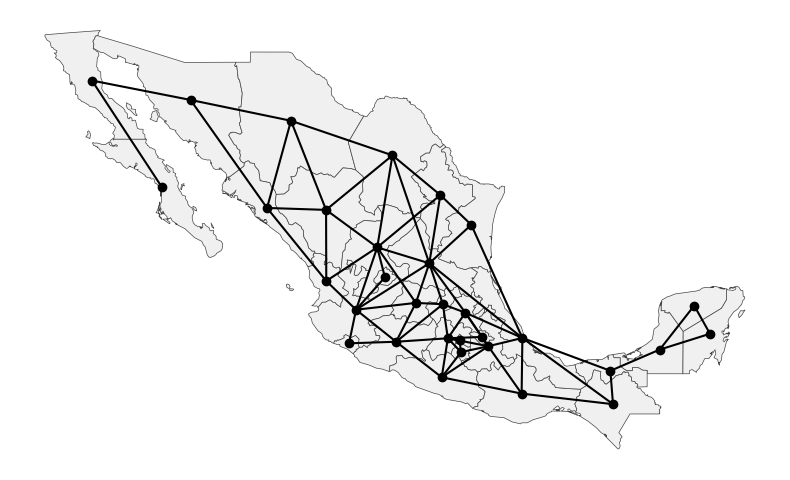

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, color="#f0f0f0", edgecolor="#444", linewidth=0.5)

H.plot(gdf, ax=ax)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [5]:
G = H.sparse
G_csr = sp.csr_matrix(G)

In [6]:
np.random.seed(42)

num_nodes = G.shape[0]
nodes = list(range(num_nodes))

od_pairs = []

while len(od_pairs) < 20:
    origin = np.random.choice(nodes)
    dest = np.random.choice(nodes)
    if origin != dest:
        volume = np.random.randint(10, 200)
        od_pairs.append({"origin": origin, "destination": dest, "volume": volume})

flows_df = pd.DataFrame(od_pairs)

In [7]:
frlm_capacity = FRLM(vehicle_range=200, p_facilities=5, capacity=300)
frlm_capacity.add_network(G_csr)
frlm_capacity.add_flows(flows_df)

FRLM(vehicle_range=200, p=5, capacity=300)

In [8]:
facility_combinations = frlm_capacity.generate_path_refueling_combinations(
    start=1, stop=3
)

Generating combinations: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


In [9]:
frlm_capacity.solve(solver=pulp.GUROBI_CMD())

{'status': 'Optimal',
 'objective_value': 2542,
 'selected_facilities': [1, 10, 18, 28, 31]}

In [10]:
frlm_capacity.get_detailed_results()

{'model_parameters': {'vehicle_range': 200,
  'p_facilities': 5,
  'capacity': 300,
  'threshold': 0.0,
  'objective_type': 'flow'},
 'solution': {'status': 'Optimal',
  'objective_value': 2542.0,
  'selected_facilities': [1, 10, 18, 28, 31],
  'solution_time': 2.6},
 'solver_statistics': {},
 'coverage_statistics': {'flow_breakdown': {(6, 19): {'flow_volume': 102,
    'covered_proportion': 1.0,
    'covered_volume': 102.0},
   (14, 10): {'flow_volume': 81,
    'covered_proportion': 1.0,
    'covered_volume': 81.0},
   (28, 20): {'flow_volume': 112,
    'covered_proportion': 1.0,
    'covered_volume': 112.0},
   (25, 18): {'flow_volume': 84,
    'covered_proportion': 1.0,
    'covered_volume': 84.0},
   (10, 23): {'flow_volume': 126,
    'covered_proportion': 1.0,
    'covered_volume': 126.0},
   (3, 7): {'flow_volume': 161,
    'covered_proportion': 1.0,
    'covered_volume': 161.0},
   (2, 21): {'flow_volume': 62,
    'covered_proportion': 1.0,
    'covered_volume': 62.0},
   (1, 23)

## References

- [Upchurch, C., Kuby, M., & Lim, S. (2009). A model for location of capacitated alternative-fuel stations. Geographical Analysis, 41(1), 85-106.](https://doi.org/10.1111/j.1538-4632.2009.00744.x)

- [Hong, S., & Kuby, M. (2016). A threshold covering flow-based location model to build a critical mass of alternative-fuel stations. Journal of Transport Geography, 56, 128-137.](https://doi.org/10.1016/j.jtrangeo.2016.08.019)

- [Kuby, M., & Lim, S. (2005). The flow-refueling location problem for alternative-fuel vehicles. Socio-Economic Planning Sciences, 39(2), 125-145.](https://doi.org/10.1016/j.seps.2004.03.001)
